In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from datetime import datetime
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
from scipy.stats import ttest_rel
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
def balanced_weighted_average(sentiment_scores, decay_factor):
    """
    Calculate a balanced weighted average of sentiment scores without biasing towards negative values.
    
    Parameters:
    - sentiment_scores: A list or pandas Series of sentiment scores (positive and negative).
    - decay_factor: A value between 0 and 1 to control the decay rate of weights; defaults to 0.95.
    
    Returns:
    - A single balanced weighted average score.
    """
    # Initialize positive and negative scores with respective weights
    positive_scores = sentiment_scores[sentiment_scores > 0]
    negative_scores = sentiment_scores[sentiment_scores < 0]
    
    # Calculate decay weights for each score in reverse order (older scores get smaller weights)
    decay_weights = decay_factor ** np.arange(len(sentiment_scores))[::-1]

    # Separate weights for positive and negative scores
    pos_weights = decay_weights[:len(positive_scores)]
    neg_weights = decay_weights[:len(negative_scores)]

    # Calculate the weighted average for positive and negative scores separately
    pos_weighted_avg = (positive_scores * pos_weights).sum() / pos_weights.sum() if len(pos_weights) > 0 else 0
    neg_weighted_avg = (negative_scores * neg_weights).sum() / neg_weights.sum() if len(neg_weights) > 0 else 0

    # Return the balanced average by combining positive and negative averages equally
    balanced_avg = (pos_weighted_avg + neg_weighted_avg) / 2

    return balanced_avg

In [3]:
def compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date, end_date, include_volume, include_trend,
                                    include_log_returns, include_rpm, include_volatility, include_stock_news, include_global_news):
    """
    Computes stock sentiment changes and associated metrics.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - interval_days: Number of days for interval calculations.
    - decay_factor: Decay factor for weighted averages.
    - start_date: Start date for filtering data.
    - end_date: End date for filtering data.
    - include_volume: Boolean indicating whether to include volume data.
    - include_stock_news: Boolean indicating whether to include stock-specific news sentiment.
    - include_global_news: Boolean indicating whether to include global news sentiment.

    Returns:
    - Dictionary containing metrics DataFrames for each stock symbol.
    """
    # Initialize dictionaries to hold data
    df_stock_news_sentiment_scores_dict = {}
    df_news_sentiment_scores_dict = {}
    df_stock_data_dict = {}
    results = {}

    # Ensure dates are in datetime.date format
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d').date()

    for symbol in stock_symbols:
        # Load data
        try:
            if include_stock_news:
                df_stock_news_sentiment_scores_dict[symbol] = pd.read_csv(
                    f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/stock_news_sentiment_scores/stock_news_sentiment_analysis_results_{symbol}.csv'
                )
            if include_global_news:
                df_news_sentiment_scores_dict[symbol] = pd.read_csv(
                    f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/news_sentiment_scores/2000-2024/sentiment_analysis_results_{symbol}.csv'
                )
            df_stock_data_dict[symbol] = pd.read_csv(
                f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stocks data/stock_data_{symbol}.csv'
            )
        except FileNotFoundError as e:
            print(f"Error loading data for {symbol}: {e}")
            continue

        # Rename sentiment score columns for clarity
        if include_global_news:
            df_news_sentiment_scores_dict[symbol] = df_news_sentiment_scores_dict[symbol].rename(
                columns={'weighted compound sentiment score': 'weighted compound news sentiment score'}
            )
        if include_stock_news:
            df_stock_news_sentiment_scores_dict[symbol] = df_stock_news_sentiment_scores_dict[symbol].rename(
                columns={'weighted compound sentiment score': 'weighted compound stock sentiment score'}
            )

        # Convert 'Date' columns to datetime.date format
        dataframes = [df_stock_data_dict[symbol]]
        if include_stock_news:
            dataframes.append(df_stock_news_sentiment_scores_dict[symbol])
        if include_global_news:
            dataframes.append(df_news_sentiment_scores_dict[symbol])

        for df in dataframes:
            df['Date'] = pd.to_datetime(df['Date']).dt.date

        # Filter data by date range
        filtered_stock = df_stock_data_dict[symbol][
            (df_stock_data_dict[symbol]['Date'] >= start_date) &
            (df_stock_data_dict[symbol]['Date'] <= end_date)
        ]
        if include_stock_news:
            filtered_stock_sentiment = df_stock_news_sentiment_scores_dict[symbol][
                (df_stock_news_sentiment_scores_dict[symbol]['Date'] >= start_date) &
                (df_stock_news_sentiment_scores_dict[symbol]['Date'] <= end_date)
            ]
        if include_global_news:
            filtered_news_sentiment = df_news_sentiment_scores_dict[symbol][
                (df_news_sentiment_scores_dict[symbol]['Date'] >= start_date) &
                (df_news_sentiment_scores_dict[symbol]['Date'] <= end_date)
            ]

        # Merge datasets
        merged_data = filtered_stock
        if include_stock_news:
            merged_data = pd.merge(merged_data, filtered_stock_sentiment, on='Date', how='left')
            merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
        if include_global_news:
            merged_data = pd.merge(merged_data, filtered_news_sentiment, on='Date', how='left')
            merged_data['weighted compound news sentiment score'].fillna(0, inplace=True)

        # Sort data by date
        merged_data.sort_values(by='Date', inplace=True)

        # Check if sufficient data exists
        if len(merged_data) < interval_days:
            print(f"Not enough data for {symbol} with interval_days = {interval_days}. Skipping.")
            continue
        
        # Initialize lists to store metrics
        closing_price_list, next_day_price_list, balanced_avg_stock_sentiment_list, balanced_avg_news_sentiment_list = [], [], [], []
        price_bin_list, sma_list, sma_bin_list, date_list = [], [], [], []
        log_returns_list, volatility_list, rpm_list, volume_list = [], [], [], []

        # Compute metrics
        for i in range(interval_days, len(merged_data)):
            date_d = merged_data['Date'].iloc[i]
            volume_d = merged_data['Volume'].iloc[i] if include_volume else None

            # Closing price 
            closing_price = merged_data['Close'].iloc[i]
            next_closing_price = merged_data['Close'].shift(-1).iloc[i]

            # SMA
            sma_next = merged_data['Close'].shift(-1).iloc[i-interval_days:i].mean()
            sma = merged_data['Close'].iloc[i-interval_days:i].mean()

            # Relative price metric (RPM)
            rpm = closing_price/sma
            
            # Log returns
            previous_day_closing = merged_data['Close'].shift(1).iloc[i]
            log_returns = np.log(closing_price/previous_day_closing)

            # Volatility
            volatility = np.log(merged_data['Close']/merged_data['Close'].shift(1)).iloc[i-interval_days:i].std()

            # Balanced weighted averages
            if include_stock_news:
                stock_sentiment_scores = merged_data['weighted compound stock sentiment score'].iloc[i:i + interval_days]
                balanced_avg_stock_sentiment = balanced_weighted_average(stock_sentiment_scores, decay_factor)
                balanced_avg_stock_sentiment_list.append(balanced_avg_stock_sentiment)
            if include_global_news:
                news_sentiment_scores = merged_data['weighted compound news sentiment score'].iloc[i:i + interval_days]
                balanced_avg_news_sentiment = balanced_weighted_average(news_sentiment_scores, decay_factor)
                balanced_avg_news_sentiment_list.append(balanced_avg_news_sentiment)

            # SMA difference as a binary variable
            sma_bin = 0 if len(sma_list) > 0 and sma_list[-1] > sma_next else 1

            # Price difference as a binary variable
            price_bin = 0  if len(closing_price_list) > 0 and closing_price > next_closing_price else 1
             
            # Append metrics
            date_list.append(date_d)
            price_bin_list.append(price_bin)
            
            sma_list.append(sma_next)
            sma_bin_list.append(sma_bin)
            next_day_price_list.append(next_closing_price)
            closing_price_list.append(closing_price)
            
            if include_volume:
                volume_list.append(volume_d)
            if include_rpm:
                rpm_list.append(rpm)
            if include_volatility:
                volatility_list.append(volatility)
            if include_log_returns:
                log_returns_list.append(log_returns)

        if include_trend:
            trend_column = "Trend"
            merged_data[trend_column] = (
                (merged_data['Close'] > merged_data['Close'].shift(1))
                .astype(int)
                .rolling(interval_days)
                .sum()
            )
        # Store results
        results[symbol] = pd.DataFrame({
            'Date': date_list,
            f'{symbol}_Next_Closing_Price_{interval_days}d': merged_data['Close'][interval_days:].shift(-1),
            f'{symbol}_Closing_Price_{interval_days}d': merged_data['Close'][interval_days:],
            f'{symbol}_Price_Bin_{interval_days}d': price_bin_list,
            f'{symbol}_SMA_{interval_days}d': sma_list,
            f'{symbol}_SMA_Bin_{interval_days}d': sma_bin_list,
        })
        if include_log_returns:
            results[symbol][f'{symbol}_Log_Returns_{interval_days}d'] = log_returns_list
        if include_rpm:
            results[symbol][f'{symbol}_RPM_{interval_days}d'] = rpm_list
        if include_volatility:
            results[symbol][f'{symbol}_Volatility_{interval_days}d'] = volatility_list
        if include_volume:
            results[symbol][f'{symbol}_Volume_Traded_{interval_days}d'] = volume_list
        if include_stock_news:
            results[symbol][f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d'] = balanced_avg_stock_sentiment_list
        if include_global_news:
            results[symbol][f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d'] = balanced_avg_news_sentiment_list
        if include_trend:
            results[symbol][f'{symbol}_Trend_{interval_days}d'] = list(merged_data[trend_column][interval_days:])
    return results

In [103]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
decay_factor = 0.95
results = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date='2011-11-01', end_date='2023-12-31', include_volume=True, include_stock_news=True, include_global_news = True, include_log_returns=True, include_volatility=True, include_rpm=True, include_trend=True)

/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_95265/2807413388.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_95265/2807413388.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [104]:
results['GOOG']

,Date,GOOG_Next_Closing_Price_14d,GOOG_Closing_Price_14d,GOOG_Price_Bin_14d,GOOG_SMA_14d,GOOG_SMA_Bin_14d,GOOG_Log_Returns_14d,GOOG_RPM_14d,GOOG_Volatility_14d,GOOG_Volume_Traded_14d,GOOG_Balanced_Avg_Stock_Sentiment_14d,GOOG_Balanced_Avg_News_Sentiment_14d,GOOG_Trend_14d
14,2011-11-21,14.478663,14.502129,1,15.015782,1,-0.023712,0.966055,0.014357,119931948,0.240650,0.066216,7.0
15,2011-11-22,14.231777,14.478663,0,15.007188,0,-0.001619,0.964230,0.015426,96115788,0.240650,0.066216,6.0
16,2011-11-23,14.054288,14.231777,0,14.958349,0,-0.017199,0.948331,0.015140,92938968,0.240650,0.049791,5.0
17,2011-11-25,14.683111,14.054288,1,14.899257,0,-0.012550,0.939561,0.014313,62433504,0.240650,0.049791,5.0
18,2011-11-28,14.551805,14.683111,0,14.863346,0,0.043770,0.985493,0.014516,113042844,0.240650,0.039949,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,2023-12-22,141.170441,141.140518,1,134.563227,1,0.007591,1.055710,0.018500,26514600,-0.080858,0.012900,9.0
3056,2023-12-26,140.023270,141.170441,0,135.313511,1,0.000212,1.049101,0.017126,16780300,-0.080858,0.012900,9.0
3057,2023-12-27,139.883621,140.023270,0,136.050970,1,-0.008159,1.034806,0.017084,19628600,-0.080858,0.012900,9.0
3058,2023-12-28,139.344955,139.883621,0,136.286102,1,-0.000998,1.028171,0.017127,16045700,-0.070336,0.000000,8.0


In [6]:
def fit_sentiments_vs_metric_as_mlr(stock_symbols, results, interval_days, metric, 
                                                 include_volume, include_stock_news, include_global_news, 
                                                 include_log_returns, include_rpm, include_volatility, include_trend, 
                                                 n_splits=5):
    """
    Fits multilinear regression of sentiment scores against either SMA or price difference using Time-Series cross-validation.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to plot.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - include_log_returns: Boolean to include log returns as a feature.
    - include_rpm: Boolean to include RPM as a feature.
    - include_volatility: Boolean to include volatility as a feature.
    - include_trend: Boolean to include trend as a feature.
    - n_splits: Number of splits for Time-Series cross-validation.

    Returns:
    - Dictionary containing models for each fold, average MSEs, and per-fold MSEs for each stock symbol.
    """
    # Initialize dictionaries to store models and MSEs
    mlr_model = {}
    avg_mse = {}
    fold_mse = {}

    for symbol in stock_symbols:
        # Construct feature and target column names dynamically
        features = []
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        if include_log_returns:
            features.append(f'{symbol}_Log_Returns_{interval_days}d')
        if include_rpm:
            features.append(f'{symbol}_RPM_{interval_days}d')
        if include_volatility:
            features.append(f'{symbol}_Volatility_{interval_days}d')
        if include_trend:
            features.append(f'{symbol}_Trend_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_{interval_days}d'
        elif metric == 'closing_price':
            metric_col = f'{symbol}_Next_Closing_Price_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'closing_price'. Skipping.")
            continue

        data = results[symbol]

        # Check if the expected columns exist in the DataFrame for the current symbol
        if symbol in results and all(col in data.columns for col in features + [metric_col]):
            # Handle the special case for 'closing_price'
            if metric == 'closing_price':
                X = data[features].iloc[:-1].dropna().values  # Drop last row for features
                y = data[metric_col].iloc[:-1].dropna().values  # Drop last row for target
            else:
                X = data[features].dropna().values
                y = data[metric_col].dropna().values

            # Initialize Time-Series cross-validation
            tscv = TimeSeriesSplit(n_splits=n_splits)

            fold_mse[symbol] = []
            fold_models = []

            # Perform Time-Series cross-validation
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Define the pipeline
                pipeline = Pipeline([
                    ('scale', StandardScaler()),
                    ('mlr', LinearRegression())
                ])

                # Fit the model and predict
                pipeline.fit(X_train, y_train)
                y_pred_test = pipeline.predict(X_test)

                # Calculate and store MSE for this fold
                fold_mse[symbol].append(mse(y_test, y_pred_test))

                # Save the trained model for this fold
                fold_models.append(pipeline)

            # Calculate the average MSE across folds
            avg_mse[symbol] = np.mean(fold_mse[symbol])

            # Store the models for this symbol
            mlr_model[symbol] = fold_models

    return {'models': mlr_model, 'avg_mse': avg_mse}


In [7]:
fit_sentiments_vs_metric_as_mlr(stock_symbols, results, interval_days, 'closing_price', include_volume = True, include_stock_news = True, include_global_news = True, include_log_returns=True, include_rpm=True, include_volatility=True, include_trend=True)['avg_mse']

{'GOOG': np.float64(1468.482885938481),
 'MSFT': np.float64(7886.56246462693),
 'NVDA': np.float64(235.30498225454454),
 'AMZN': np.float64(1700.8381843677985),
 'AAPL': np.float64(3243.4954254544014)}

In [19]:
def fit_sentiments_vs_metric_as_xgb(stock_symbols, results, interval_days, metric, 
                                                 include_volume, include_stock_news, include_global_news, 
                                                 include_log_returns, include_rpm, include_volatility, include_trend, 
                                                 n_splits=5):
    """
    Fits XGBoost regression of sentiment scores against either SMA or price difference using Time-Series cross-validation.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to plot.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - include_log_returns: Boolean to include log returns as a feature.
    - include_rpm: Boolean to include RPM as a feature.
    - include_volatility: Boolean to include volatility as a feature.
    - include_trend: Boolean to include trend as a feature.
    - n_splits: Number of splits for Time-Series cross-validation.

    Returns:
    - Dictionary containing models for each fold, average MSEs, and per-fold MSEs for each stock symbol.
    """
    # Initialize dictionaries to store models and MSEs
    xgb_model = {}
    avg_mse = {}
    fold_mse = {}

    for symbol in stock_symbols:
        # Construct feature and target column names dynamically
        features = []
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        if include_log_returns:
            features.append(f'{symbol}_Log_Returns_{interval_days}d')
        if include_rpm:
            features.append(f'{symbol}_RPM_{interval_days}d')
        if include_volatility:
            features.append(f'{symbol}_Volatility_{interval_days}d')
        if include_trend:
            features.append(f'{symbol}_Trend_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_{interval_days}d'
        elif metric == 'closing_price':
            metric_col = f'{symbol}_Next_Closing_Price_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'closing_price'. Skipping.")
            continue

        data = results[symbol]

        # Check if the expected columns exist in the DataFrame for the current symbol
        if symbol in results and all(col in data.columns for col in features + [metric_col]):
            # Handle the special case for 'closing_price'
            if metric == 'closing_price':
                X = data[features].iloc[:-1].dropna().values  # Drop last row for features
                y = data[metric_col].iloc[:-1].dropna().values  # Drop last row for target
            else:
                X = data[features].dropna().values
                y = data[metric_col].dropna().values

            # Initialize Time-Series cross-validation
            tscv = TimeSeriesSplit(n_splits=n_splits)

            fold_mse[symbol] = []
            fold_models = []

            # Perform Time-Series cross-validation
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Define the pipeline
                pipeline = Pipeline([
                    ('scale', StandardScaler()),
                    ('xgb', XGBRegressor(objective='reg:squarederror', n_estimators=800, 
                        max_depth=6, learning_rate=0.1))
                ])

                # Fit the model and predict
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                # Calculate and store MSE for this fold
                fold_mse[symbol].append(mse(y_test, y_pred))

                # Save the trained model for this fold
                fold_models.append(pipeline)

            # Calculate the average MSE across folds
            avg_mse[symbol] = np.mean(fold_mse[symbol])

            # Store the models for this symbol
            xgb_model[symbol] = fold_models

    return {'models': xgb_model, 'avg_mse': avg_mse}


In [20]:
fit_sentiments_vs_metric_as_xgb(
    stock_symbols=stock_symbols,
    results=results,
    interval_days=interval_days,
    metric='sma',
    include_volume=True,
    include_stock_news=True,
    include_global_news=True,
    include_log_returns=True,
    include_rpm=True,
    include_volatility=True,
    include_trend=True
)['avg_mse']

{'GOOG': np.float64(1355.79121032311),
 'MSFT': np.float64(4892.974481883433),
 'NVDA': np.float64(216.26986596636658),
 'AMZN': np.float64(1720.1634908259482),
 'AAPL': np.float64(2464.2478531757984)}

In [21]:
def fit_sentiments_vs_metric_as_gb(stock_symbols, results, interval_days, metric, 
                                                 include_volume, include_stock_news, include_global_news, 
                                                 include_log_returns, include_rpm, include_volatility, include_trend, 
                                                 n_splits=5):
    """
    Fits Gradient Boosted Trees regression of sentiment scores against either SMA or price difference using Time-Series cross-validation.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify either 'sma' or 'price_diff' to choose which metric to plot.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - include_log_returns: Boolean to include log returns as a feature.
    - include_rpm: Boolean to include RPM as a feature.
    - include_volatility: Boolean to include volatility as a feature.
    - include_trend: Boolean to include trend as a feature.
    - n_splits: Number of splits for Time-Series cross-validation.

    Returns:
    - Dictionary containing models and average MSEs for each stock symbol.
    """
    # Initialize dictionaries to store models and MSEs
    gb_model = {}
    avg_mse = {}
    fold_mse = {}

    for symbol in stock_symbols:
        # Construct feature and target column names dynamically
        features = []
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        if include_log_returns:
            features.append(f'{symbol}_Log_Returns_{interval_days}d')
        if include_rpm:
            features.append(f'{symbol}_RPM_{interval_days}d')
        if include_volatility:
            features.append(f'{symbol}_Volatility_{interval_days}d')
        if include_trend:
            features.append(f'{symbol}_Trend_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_{interval_days}d'
        elif metric == 'closing_price':
            metric_col = f'{symbol}_Next_Closing_Price_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'price_diff'. Skipping.")
            continue

        data = results[symbol]

        # Check if the expected columns exist in the DataFrame for the current symbol
        if symbol in results and all(col in data.columns for col in features + [metric_col]):
            # Handle the special case for 'closing_price'
            if metric == 'closing_price':
                X = data[features].iloc[:-1].dropna().values  # Drop last row for features
                y = data[metric_col].iloc[:-1].dropna().values  # Drop last row for target
            else:
                X = data[features].dropna().values
                y = data[metric_col].dropna().values

            # Initialize Time-Series cross-validation
            tscv = TimeSeriesSplit(n_splits=n_splits)

            fold_mse[symbol] = []
            fold_models = []

            # Perform Time-Series cross-validation
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Define the pipeline
                pipeline = Pipeline([
                    ('scale', StandardScaler()),
                    ('gb', GradientBoostingRegressor(n_estimators=1200, max_depth=6, learning_rate=0.01))
                ])

                # Fit the model and predict
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                # Calculate and store MSE for this fold
                fold_mse[symbol].append(mse(y_test, y_pred))

                # Save the trained model for this fold
                fold_models.append(pipeline)

            # Calculate the average MSE across folds
            avg_mse[symbol] = np.mean(fold_mse[symbol])

            # Store the models for this symbol
            gb_model[symbol] = fold_models

    return  {'models': gb_model, 'avg_mse': avg_mse}


In [15]:
data = fit_sentiments_vs_metric_as_gb(
    stock_symbols=stock_symbols,
    results=results,
    interval_days=interval_days,
    metric='sma',
    include_volume=True,
    include_stock_news=True,
    include_global_news=True,
    include_log_returns=True,
    include_rpm=True,
    include_volatility=True,
    include_trend=True
)

In [17]:
data['avg_mse']

{'GOOG': np.float64(1344.508410696633),
 'MSFT': np.float64(4772.009774730004),
 'NVDA': np.float64(212.97651364432986),
 'AMZN': np.float64(1782.5747145886712),
 'AAPL': np.float64(2463.871115146568)}

In [22]:
def random_guess_baseline(stock_symbols, results, interval_days, metric):
    """
    Implements a random guess baseline for binary classification without explicit splitting.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - metric: Specify the target column ('sma' or 'price_diff') for classification.

    Returns:
    - DataFrame containing metrics for each stock symbol.
    """
    # Initialize dictionary to store metrics
    metrics = {}

    for symbol in stock_symbols:
        # Define the target column
        if metric == 'sma':
            metric_col = f'{symbol}_SMA_Bin_{interval_days}d'
        if metric == 'closing_price':
            metric_col = f'{symbol}_Price_Bin_{interval_days}d'

        # Check if the required column exists
        if symbol in results and metric_col in results[symbol].columns:
            # Extract target
            data = results[symbol][[metric_col]].dropna()
            y = data[metric_col].values

            # Handle cases where y has fewer positive or negative samples
            if len(set(y)) < 2:
                print(f"Insufficient class variation for {symbol}. Skipping.")
                continue

            # Generate random predictions with probabilities matching class distribution
            class_probabilities = [np.mean(y == 0), np.mean(y == 1)]
            y_pred = np.random.choice([0, 1], size=len(y), p=class_probabilities)

            # Compute confusion matrix
            tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

            # Calculate metrics
            acc = accuracy_score(y, y_pred)
            spec = tn / (tn + fp) if (tn + fp) > 0 else 0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0
            f1 = f1_score(y, y_pred)
            roc_auc = roc_auc_score(y, y_pred)

            # Store metrics for the symbol
            metrics[symbol] = {
                "accuracy": acc,
                "specificity": spec,
                "recall": rec,
                "precision": prec,
                "NPV": npv,
                "f1_score": f1,
                "roc_auc": roc_auc
            }

    # Convert metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics)
    metrics_df.reset_index(inplace=True)
    metrics_df = metrics_df.rename(columns={"index": "Metrics"})

    return metrics_df

In [401]:
random_guess_baseline(stock_symbols, results, interval_days, metric='rpm')

,Metrics,GOOG,MSFT,NVDA,AMZN,AAPL
0,accuracy,0.525614,0.531821,0.531847,0.530131,0.528090
1,specificity,0.609904,0.634241,0.655257,0.607167,0.601190
2,recall,0.391425,0.343470,0.301370,0.408894,0.420205
3,precision,0.386612,0.338028,0.318841,0.398099,0.416546
4,NPV,0.614711,0.639843,0.636580,0.617812,0.604790
5,f1_score,0.389003,0.340728,0.309859,0.403424,0.418367
6,roc_auc,0.500665,0.488856,0.478313,0.508031,0.510698


In [23]:
def classify_sentiments_vs_metric_as_log_reg(stock_symbols, results, interval_days, include_trend,
                                             include_volume, include_stock_news, include_rpm, include_volatility,
                                             include_global_news, include_log_returns, metric, n_splits=5):
    """
    Classifies sentiment scores against either SMA or price difference using Logistic Regression with Time-Series cross-validation.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_trend: Boolean to include trend as a feature.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_rpm: Boolean to include RPM as a feature.
    - include_volatility: Boolean to include volatility as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - include_log_returns: Boolean to include log returns as a feature.
    - metric: Specify either 'sma' or 'closing_price' to choose which metric to classify.
    - n_splits: Number of splits for Time-Series cross-validation.

    Returns:
    - DataFrame containing average metrics for each stock symbol.
    - Dictionary containing trained models for each fold per stock symbol.
    """
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        features = []
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        if include_log_returns:
            features.append(f'{symbol}_Log_Returns_{interval_days}d')
        if include_rpm:
            features.append(f'{symbol}_RPM_{interval_days}d')
        if include_volatility:
            features.append(f'{symbol}_Volatility_{interval_days}d')
        if include_trend:
            features.append(f'{symbol}_Trend_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_Bin_{interval_days}d'
        elif metric == 'closing_price':
            metric_col = f'{symbol}_Price_Bin_{interval_days}d'
        else:
            print(f"Unsupported metric '{metric}' for symbol {symbol}. Skipping.")
            continue

        if symbol in results and all(col in results[symbol].columns for col in features + [metric_col]):
            data = results[symbol][features + [metric_col]].dropna()
            if data.empty:
                print(f"No data available for symbol {symbol}. Skipping.")
                continue

            X = data[features].iloc[:-1].values
            y = data[metric_col].iloc[:-1].values

            tscv = TimeSeriesSplit(n_splits=n_splits)
            fold_metrics[symbol] = {key: [] for key in ["accuracy", "specificity", "recall", "precision", "NPV", "f1_score", "roc_auc"]}
            fold_models = []

            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                log_reg_model = Pipeline([
                    ('scale', StandardScaler()),
                    ('log_reg', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
                ])
                log_reg_model.fit(X_train, y_train)
                y_pred = log_reg_model.predict(X_test)
                y_proba = log_reg_model.predict_proba(X_test)[:, 1]

                tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()

                fold_metrics[symbol]["accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics[symbol]["specificity"].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
                fold_metrics[symbol]["recall"].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
                fold_metrics[symbol]["precision"].append(tp / (tp + fp) if (tp + fp) > 0 else 0)
                fold_metrics[symbol]["NPV"].append(tn / (tn + fn) if (tn + fn) > 0 else 0)
                fold_metrics[symbol]["f1_score"].append(f1_score(y_test, y_pred))
                fold_metrics[symbol]["roc_auc"].append(roc_auc_score(y_test, y_proba))

                fold_models.append(log_reg_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }
            models[symbol] = fold_models
        else:
            print(f"Missing required columns for {symbol}. Skipping.")

    df_metrics = pd.DataFrame(df_metrics)
    df_metrics.reset_index(inplace=True)
    df_metrics = df_metrics.rename(columns={"index": "Metrics"})

    return df_metrics, models, fold_metrics


In [105]:
classify_sentiments_vs_metric_as_log_reg(stock_symbols, results, interval_days, include_global_news=True, include_volume=True, include_stock_news=True, include_log_returns=True, include_trend=True, include_volatility=True, include_rpm=True, metric='sma')[0]

,Metrics,GOOG,MSFT,NVDA,AMZN,AAPL
0,accuracy,0.863116,0.868639,0.889546,0.876529,0.893097
1,specificity,0.791313,0.766221,0.832676,0.815863,0.878093
2,recall,0.907345,0.920872,0.923180,0.908994,0.906175
3,precision,0.865629,0.879949,0.905677,0.890957,0.917821
4,NPV,0.854181,0.835689,0.848902,0.854009,0.850014
5,f1_score,0.885587,0.899575,0.913802,0.899417,0.911351
6,roc_auc,0.942323,0.944354,0.950429,0.950713,0.962200


In [83]:
def classify_sentiments_vs_metric_as_gb(stock_symbols, results, interval_days, include_volume, include_stock_news, include_global_news, 
                                                     include_log_returns, include_rpm, include_volatility, include_trend, metric, n_splits=5):
    """
    Performs Time-Series cross-validation for Gradient Boosting classifiers and calculates metrics.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_volatility: Boolean to include volatility as a feature.
    - include_trend: Boolean to include trend as a feature.
    - include_log_returns: Boolean to include log returns as a feature.
    - include_rpm: Boolean to include RPM as a feature.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - n_splits: Number of splits for Time-Series cross-validation.

    Returns:
    - DataFrame containing average metrics for each stock symbol across folds.
    - Dictionary containing trained models for each stock symbol.
    """
    # Initialize dictionaries to store models and metrics
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        # Dynamically construct feature column names based on flags
        features = []
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        if include_log_returns:
            features.append(f'{symbol}_Log_Returns_{interval_days}d')
        if include_rpm:
            features.append(f'{symbol}_RPM_{interval_days}d')
        if include_volatility:
            features.append(f'{symbol}_Volatility_{interval_days}d')
        if include_trend:
            features.append(f'{symbol}_Trend_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_Bin_{interval_days}d'
        elif metric == 'closing_price':
            metric_col = f'{symbol}_Price_Bin_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'closing_price'. Skipping.")
            continue

        # Check if required columns exist
        if symbol in results and all(col in results[symbol].columns for col in features + [metric_col]):
            # Prepare the data
            data = results[symbol][features + [metric_col]].dropna()
            X = data[features].values
            y = data[metric_col].values

            # Initialize Time-Series cross-validation
            tscv = TimeSeriesSplit(n_splits=n_splits)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []

            # Handle cases where y has fewer positive or negative samples
            if len(set(y)) < 2:
                print(f"Insufficient class variation for {symbol}. Skipping.")
                continue

            # Perform Time-Series cross-validation
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Train Gradient Boosting model
                gb_model = Pipeline([
                    ('scale', StandardScaler()),
                    ('gb_reg', GradientBoostingClassifier(n_estimators=1200,
                                                          max_depth=6,
                                                          learning_rate=0.01))
                ])
                gb_model.fit(X_train, y_train)
                y_pred = gb_model.predict(X_test)
                y_proba = gb_model.predict_proba(X_test)[:, 1]

                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                rec = tp / (tp + fn) if (tp + fn) > 0 else 0
                prec = tp / (tp + fp) if (tp + fp) > 0 else 0
                npv = tn / (tn + fn) if (tn + fn) > 0 else 0
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)

                # Append metrics
                fold_metrics[symbol]["accuracy"].append(acc)
                fold_metrics[symbol]["specificity"].append(spec)
                fold_metrics[symbol]["recall"].append(rec)
                fold_metrics[symbol]["precision"].append(prec)
                fold_metrics[symbol]["NPV"].append(npv)
                fold_metrics[symbol]["f1_score"].append(f1)
                fold_metrics[symbol]["roc_auc"].append(roc_auc)

                # Save the model for this fold
                fold_models.append(gb_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }

            # Save all models for this symbol
            models[symbol] = fold_models

    # Convert metrics to a DataFrame
    df_metrics = pd.DataFrame(df_metrics)
    df_metrics.reset_index(inplace=True)
    df_metrics = df_metrics.rename(columns={"index": "Metrics"})

    return df_metrics, models, fold_metrics


In [26]:
def classify_sentiments_vs_metric_as_xgb(stock_symbols, results, interval_days, include_volume, include_stock_news, 
                                                     include_global_news, include_log_returns, include_rpm, include_volatility, 
                                                     include_trend, metric, n_splits=5):
    """
    Performs Time-Series cross-validation for XGBoost classifiers and calculates metrics.

    Parameters:
    - stock_symbols: List of stock symbols to process.
    - results: Dictionary with stock data DataFrames.
    - interval_days: The interval of days over which metrics are calculated.
    - include_volatility: Boolean to include volatility as a feature.
    - include_trend: Boolean to include trend as a feature.
    - include_log_returns: Boolean to include log returns as a feature.
    - include_rpm: Boolean to include RPM as a feature.
    - include_volume: Boolean to include volume data as a feature.
    - include_stock_news: Boolean to include stock news sentiment as a feature.
    - include_global_news: Boolean to include global news sentiment as a feature.
    - n_splits: Number of splits for Time-Series cross-validation.

    Returns:
    - DataFrame containing average metrics for each stock symbol across folds.
    - Dictionary containing trained models for each stock symbol.
    """
    # Initialize dictionaries to store models and metrics
    models = {}
    df_metrics = {}
    fold_metrics = {}

    for symbol in stock_symbols:
        # Dynamically construct feature column names based on flags
        features = []
        if include_global_news:
            features.append(f'{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d')
        if include_stock_news:
            features.append(f'{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d')
        if include_volume:
            features.append(f'{symbol}_Volume_Traded_{interval_days}d')
        if include_log_returns:
            features.append(f'{symbol}_Log_Returns_{interval_days}d')
        if include_rpm:
            features.append(f'{symbol}_RPM_{interval_days}d')
        if include_volatility:
            features.append(f'{symbol}_Volatility_{interval_days}d')
        if include_trend:
            features.append(f'{symbol}_Trend_{interval_days}d')

        if metric == 'sma':
            metric_col = f'{symbol}_SMA_Bin_{interval_days}d'
        elif metric == 'closing_price':
            metric_col = f'{symbol}_Price_Bin_{interval_days}d'
        else:
            print(f"Unknown metric '{metric}'. Choose 'sma' or 'closing_price'. Skipping.")
            continue

        # Check if required columns exist
        if symbol in results and all(col in results[symbol].columns for col in features + [metric_col]):
            # Prepare the data
            data = results[symbol][features + [metric_col]].dropna()
            X = data[features].values
            y = data[metric_col].values

            # Initialize Time-Series cross-validation
            tscv = TimeSeriesSplit(n_splits=n_splits)

            fold_metrics[symbol] = {
                "accuracy": [],
                "specificity": [],
                "recall": [],
                "precision": [],
                "NPV": [],
                "f1_score": [],
                "roc_auc": []
            }
            fold_models = []

            # Handle cases where y has fewer positive or negative samples
            if len(set(y)) < 2:
                print(f"Insufficient class variation for {symbol}. Skipping.")
                continue

            # Perform Time-Series cross-validation
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Compute scale_pos_weight for class imbalance
                scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if len(y_train[y_train == 1]) > 0 else 1

                # Train XGBoost model
                xgb_model = Pipeline([
                    ('scale', StandardScaler()),
                    ('xgb_reg', xgb.XGBClassifier(n_estimators=1200,
                                                  max_depth=12,
                                                  learning_rate=0.01,
                                                  scale_pos_weight=scale_pos_weight,
                                                  eval_metric="logloss"))
                ])
                xgb_model.fit(X_train, y_train)
                y_pred = xgb_model.predict(X_test)
                y_proba = xgb_model.predict_proba(X_test)[:, 1]

                # Compute confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

                # Calculate metrics
                acc = accuracy_score(y_test, y_pred)
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                rec = tp / (tp + fn) if (tp + fn) > 0 else 0
                prec = tp / (tp + fp) if (tp + fp) > 0 else 0
                npv = tn / (tn + fn) if (tn + fn) > 0 else 0
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)

                # Append metrics
                fold_metrics[symbol]["accuracy"].append(acc)
                fold_metrics[symbol]["specificity"].append(spec)
                fold_metrics[symbol]["recall"].append(rec)
                fold_metrics[symbol]["precision"].append(prec)
                fold_metrics[symbol]["NPV"].append(npv)
                fold_metrics[symbol]["f1_score"].append(f1)
                fold_metrics[symbol]["roc_auc"].append(roc_auc)

                # Save the model for this fold
                fold_models.append(xgb_model)

            # Store average metrics across folds
            df_metrics[symbol] = {
                "accuracy": np.mean(fold_metrics[symbol]["accuracy"]),
                "specificity": np.mean(fold_metrics[symbol]["specificity"]),
                "recall": np.mean(fold_metrics[symbol]["recall"]),
                "precision": np.mean(fold_metrics[symbol]["precision"]),
                "NPV": np.mean(fold_metrics[symbol]["NPV"]),
                "f1_score": np.mean(fold_metrics[symbol]["f1_score"]),
                "roc_auc": np.mean(fold_metrics[symbol]["roc_auc"])
            }

            # Save all models for this symbol
            models[symbol] = fold_models

    # Convert metrics to a DataFrame
    df_metrics = pd.DataFrame(df_metrics)
    df_metrics.reset_index(inplace=True)
    df_metrics = df_metrics.rename(columns={"index": "Metrics"})

    return df_metrics, models, fold_metrics


In [142]:
def predict_with_model(symbol, subset_data, model, features):
    """
    Predicts outcomes using the trained model on a subset of data.

    Parameters:
    - symbol: Stock symbol to use for prediction.
    - subset_data: DataFrame containing the subset of data for prediction.
    - model: Trained models for each symbol from the function output.
    - features: List of feature columns to use for prediction.

    Returns:
    - List of predictions for the subset of data.
    """
    if symbol not in model:
        raise ValueError(f"No trained model found for symbol: {symbol}")

    # Select the first model (e.g., from the first fold) for simplicity
    trained_pipeline = model[symbol][0]

    # Extract features for the subset
    X_subset = subset_data[features].values

    # Predict using the pipeline
    predictions = trained_pipeline.predict(X_subset)

    return predictions.tolist()

In [143]:
def predict_probability_with_model(symbol, subset_data, models, features):
    """
    Predicts probabilities of the positive class using the trained model on a subset of data.

    Parameters:
    - symbol: Stock symbol to use for prediction.
    - subset_data: DataFrame containing the subset of data for prediction.
    - models: Trained models for each symbol from the function output.
    - features: List of feature columns to use for prediction.

    Returns:
    - List of probabilities for the subset of data.
    """
    if symbol not in models:
        raise ValueError(f"No trained model found for symbol: {symbol}")

    # Select the first model (e.g., from the first fold) for simplicity
    trained_pipeline = models[symbol][0]

    # Extract features for the subset
    X_subset = subset_data[features].values

    # Predict probabilities using the pipeline
    probabilities = trained_pipeline.predict_proba(X_subset)[:, 1]

    return probabilities.tolist()

In [144]:
metric = 'sma'

In [145]:
XGB_model_with_news = classify_sentiments_vs_metric_as_xgb(stock_symbols, results, interval_days, include_global_news=True, include_stock_news=True, include_volume=True, include_log_returns=False, include_rpm=False, include_volatility=False, include_trend=False, metric=metric)
XGB_model_without_news = classify_sentiments_vs_metric_as_xgb(stock_symbols, results, interval_days, include_global_news=False, include_stock_news=False, include_volume=True, include_log_returns=False, include_rpm=False, include_volatility=False, include_trend=False, metric=metric)

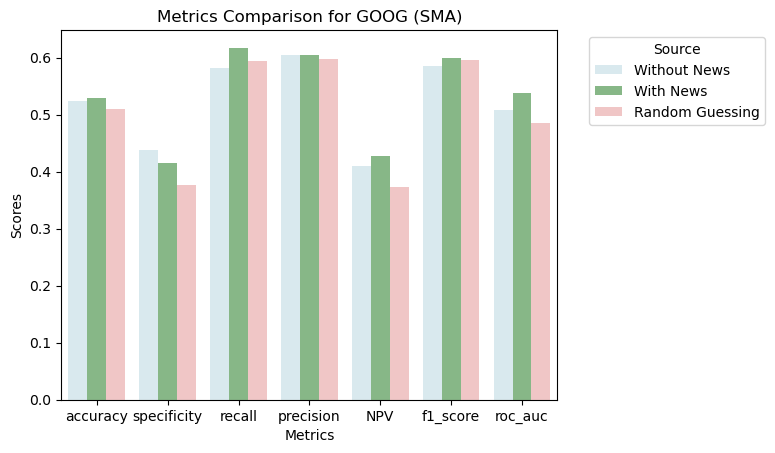

In [34]:
y_without_news = XGB_model_without_news[0]
y_with_news= XGB_model_with_news[0]
y_random = random_guess_baseline(stock_symbols, results, interval_days, metric)

y_without_news['Source'] = 'Without News'
y_with_news['Source'] = 'With News'
y_random['Source'] = 'Random Guessing'

combined_data = pd.concat([y_without_news, y_with_news, y_random])

stock_data = combined_data[['Metrics', 'GOOG', 'Source']].rename(columns={'GOOG': 'Score'})

# Add a barplot to fill the boxes
sns.barplot(
    x='Metrics', y='Score', hue='Source',
    data=stock_data,
    palette={'Random Guessing': 'lightcoral', 'Without News': 'lightblue', 'With News': 'green'},
    alpha=0.5  # Add transparency to bar plot
)

# Customize each subplot
plt.title(f'Metrics Comparison for {'GOOG'} ({'SMA'})')
plt.ylabel('Scores')
plt.xlabel('Metrics')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Source")  # Position legend outside
plt.show()

In [46]:
all_metrics = XGB_model_with_news[2]['GOOG'].keys()                    
for symbol in stock_symbols:
    for metric in all_metrics:
        metric_without_news = np.array(XGB_model_without_news[2][symbol][metric])
        metric_with_news = np.array(XGB_model_with_news[2][symbol][metric])
        metric_diff = metric_with_news - metric_without_news
        # Perform paired t-test
        t_stat, p_value = ttest_rel(metric_without_news, metric_with_news)

        #print(f"T-statistic: {t_stat}, p-value: {p_value}")

        if p_value < 0.05:
            print(f"The difference in {metric} for {symbol} is statistically significant.")
        else:
            print(f"The difference in {metric} for {symbol} is not statistically significant.")

The difference in accuracy for GOOG is not statistically significant.
The difference in specificity for GOOG is not statistically significant.
The difference in recall for GOOG is not statistically significant.
The difference in precision for GOOG is not statistically significant.
The difference in NPV for GOOG is not statistically significant.
The difference in f1_score for GOOG is not statistically significant.
The difference in roc_auc for GOOG is not statistically significant.
The difference in accuracy for MSFT is not statistically significant.
The difference in specificity for MSFT is not statistically significant.
The difference in recall for MSFT is statistically significant.
The difference in precision for MSFT is not statistically significant.
The difference in NPV for MSFT is not statistically significant.
The difference in f1_score for MSFT is statistically significant.
The difference in roc_auc for MSFT is not statistically significant.
The difference in accuracy for NVDA 

In [166]:
symbol = 'GOOG'
features = [
                f"{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d",
                f"{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d",
                f"{symbol}_Volume_Traded_{interval_days}d"
            ]
y_pred_with_news = predict_with_model(symbol, results_for_models[symbol], XGB_model_with_news[1], features)

In [169]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
decay_factor = 0.95
results_for_models = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date='2024-01-01', end_date='2024-09-27', include_volume=True, include_stock_news=True, include_global_news = True, include_log_returns=True, include_volatility=True, include_rpm=True, include_trend=True)

/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_95265/2807413388.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_95265/2807413388.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [171]:
for symbol in stock_symbols:
    features = [
                    f"{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d",
                    f"{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d",
                    f"{symbol}_Volume_Traded_{interval_days}d"
                ]
    y_pred_with_news = predict_with_model(symbol, results_for_models[symbol], XGB_model_with_news[1], features)
    y_pred_without_news = predict_with_model(symbol, results_for_models[symbol], XGB_model_without_news[1], features[-1:])
    y_actual = results_for_models[symbol][f'{symbol}_SMA_Bin_{interval_days}d']

    # Initialize counts for the contingency table
    a = b = c = d = 0

    # Loop through each prediction
    for true, pred_A, pred_B in zip(y_actual, y_pred_with_news, y_pred_without_news):
        if pred_A == 1 and pred_B == 1:
            a += 1  # Both models are correct
        elif pred_A != 1 and pred_B == 1:
            b += 1  # Model A incorrect, Model B correct
        elif pred_A == 1 and pred_B != 1:
            c += 1  # Model A correct, Model B incorrect
        elif pred_A != 1 and pred_B != 1:
            d += 1  # Both models are incorrect
    table = [[a,b],[c,d]]
    # Perform McNemar's test
    result = mcnemar(table, exact=False)  # Use exact=True for small samples

    # Print the results
    #print(f"Statistic: {result.statistic}")
    #print(f"P-value: {result.pvalue}")

    # Interpret the p-value
    alpha = 0.05
    if result.pvalue < alpha:
        print(f"Significant difference in performance for {symbol} (reject H0).")
    else:
        print(f"No significant difference in performance for {symbol} (fail to reject H0).")

Significant difference in performance for GOOG (reject H0).
No significant difference in performance for MSFT (fail to reject H0).
No significant difference in performance for NVDA (fail to reject H0).
Significant difference in performance for AMZN (reject H0).
Significant difference in performance for AAPL (reject H0).


In [86]:
GB_model_with_all_features = classify_sentiments_vs_metric_as_gb(stock_symbols, results, interval_days=30, include_global_news=True, 
                                                               include_stock_news=True, include_volume=True, include_log_returns=True, include_rpm=True, 
                                                               include_volatility=True, include_trend=True, metric='sma')

In [47]:
XGB_model_with_all_features = classify_sentiments_vs_metric_as_xgb(stock_symbols, results, interval_days=14, include_global_news=True, 
                                                               include_stock_news=True, include_volume=True, include_log_returns=True, include_rpm=True, 
                                                               include_volatility=True, include_trend=True, metric='sma')

In [87]:
GB_model_with_all_features[0]

,Metrics,GOOG,MSFT,NVDA,AMZN,AAPL
0,accuracy,0.809496,0.797626,0.846291,0.821958,0.847478
1,specificity,0.796590,0.681754,0.654679,0.723347,0.780927
2,recall,0.818663,0.857734,0.917932,0.834366,0.887876
3,precision,0.870643,0.866332,0.861819,0.859301,0.877677
4,NPV,0.723531,0.624663,0.816890,0.712098,0.801307
5,f1_score,0.841299,0.857027,0.887343,0.843768,0.880884
6,roc_auc,0.889966,0.880047,0.883741,0.909023,0.909083


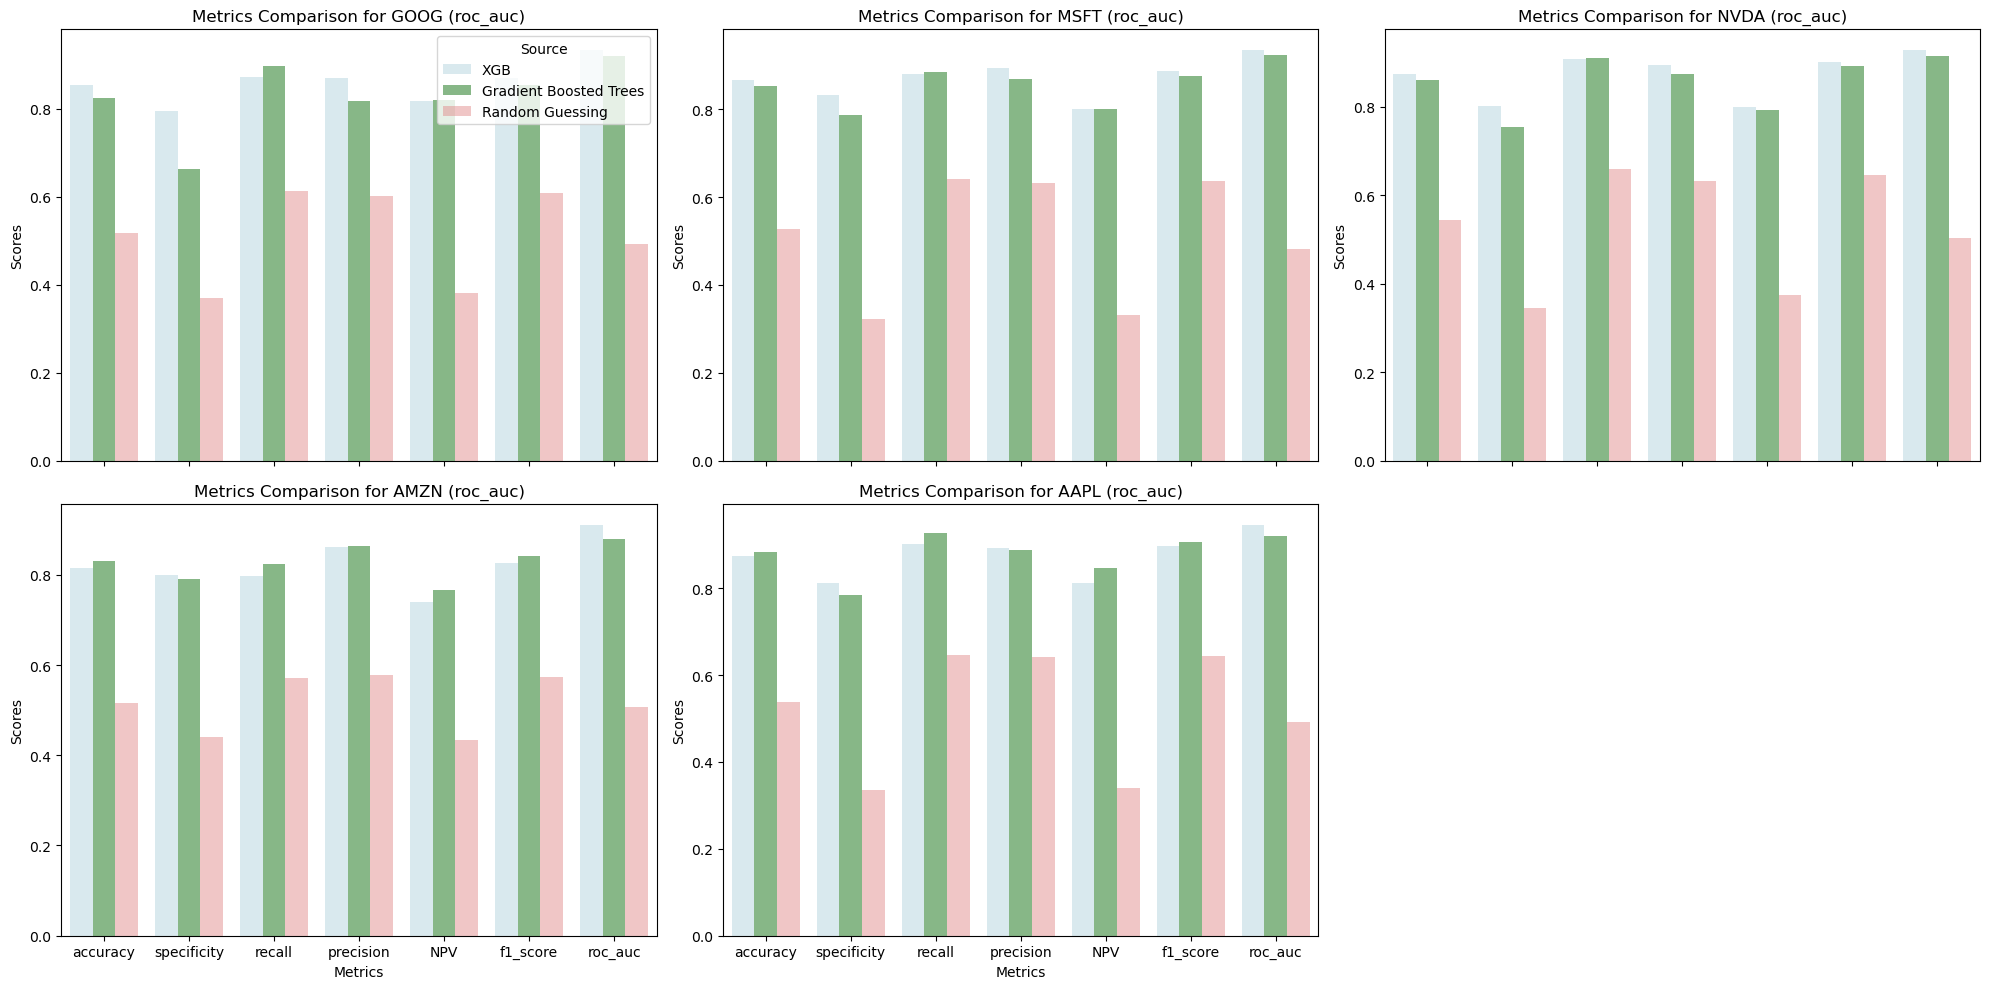

In [54]:
y_xgb = XGB_model_with_all_features[0]
y_gb = GB_model_with_all_features[0]
y_random = random_guess_baseline(stock_symbols, results, interval_days, 'sma')

y_xgb['Source'] = 'XGB'
y_gb['Source'] = 'Gradient Boosted Trees'
y_random['Source'] = 'Random Guessing'

combined_data = pd.concat([y_xgb, y_gb, y_random])

# Calculate the number of rows and columns for subplots
n_symbols = len(stock_symbols)
n_cols = 3  # Adjust this to change the number of columns per row
n_rows = (n_symbols + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), sharex=True)

# Flatten axes to handle 1D indexing, and handle cases where axes are more than required
axes = axes.flatten()

for i, symbol in enumerate(stock_symbols):
    stock_data = combined_data[['Metrics', symbol, 'Source']].rename(columns={symbol: 'Score'})

    # Add a barplot to fill the boxes
    sns.barplot(
        x='Metrics', y='Score', hue='Source',
        data=stock_data,
        ax=axes[i],
        palette={'Random Guessing': 'lightcoral', 'XGB': 'lightblue', 'Gradient Boosted Trees': 'green'},
        alpha=0.5  # Add transparency to bar plot
    )
    
    # Customize each subplot
    axes[i].set_title(f'Metrics Comparison for {symbol} ({metric})')
    axes[i].set_ylabel('Scores')
    axes[i].set_xlabel('Metrics')

    # Add legend only to the first subplot
    if i == 0:
        axes[i].legend(title='Source', loc='upper right')
    else:
        axes[i].get_legend().remove()

# Hide unused subplots (if any)
for j in range(len(stock_symbols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [51]:
budget = {'GOOG':3000, 'MSFT': 1000, 'NVDA':1000, 'AMZN':3000, 'AAPL':2000} 
total_budget = 10000
threshold_low = 0.1
threshold_high = 0.65

In [146]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']
interval_days = 14
decay_factor = 0.95
results_for_models = compute_stock_sentiment_changes(stock_symbols, interval_days, decay_factor, start_date='2024-01-01', end_date='2024-09-27', include_volume=True, include_stock_news=True, include_global_news = True, include_log_returns=True, include_volatility=True, include_rpm=True, include_trend=True)

/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_95265/2807413388.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['weighted compound stock sentiment score'].fillna(0, inplace=True)
/var/folders/wd/hyh_v63j2k7_v0q1j5942x3r0000gn/T/ipykernel_95265/2807413388.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [33]:
cumulative_return_actual = {}

for symbol in stock_symbols:
    # Read stock data
    df_stock_data_dict = pd.read_csv(
        f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stocks data/stock_data_{symbol}.csv'
    )
    df_stock_data_dict['Date'] = pd.to_datetime(df_stock_data_dict['Date'])

    # Define date range
    filter_date_left = pd.to_datetime('2024-01-22')
    filter_date_right = pd.to_datetime('2024-09-28')

    stock_data = df_stock_data_dict[
        (df_stock_data_dict['Date'] > filter_date_left) & 
        (df_stock_data_dict['Date'] < filter_date_right)
    ]

    if stock_data.empty:
        print(f"No data available for {symbol} within the specified date range.")
        continue

    # Initialize portfolio
    initial_investment = budget[symbol]
    start_price = stock_data.iloc[0]['Close']  # Buy at the first closing price
    shares = initial_investment / start_price  # Calculate number of shares
    end_price = stock_data.iloc[-1]['Close']  # Sell at the last closing price
    final_value = shares * end_price  # Portfolio value at the end

    # Calculate cumulative return
    cumulative_return_actual[symbol] = (final_value - initial_investment) / initial_investment

# Aggregate results for this simulation
total_returns_actual = sum(cumulative_return_actual[key] * budget[key] for key in stock_symbols) / total_budget
    

# Output results
print(f"Average Cumulative Return (Buy-and-Hold Strategy): {total_returns_actual:.2%}")

Average Cumulative Return (Buy-and-Hold Strategy): 24.18%


In [112]:
def train_models(model_type, stock_symbols, results, interval_days):
    if model_type == "gb":
        models_output = fit_sentiments_vs_metric_as_gb(
            stock_symbols=stock_symbols,
            results=results,
            interval_days=interval_days,
            metric="sma",
            include_volume=True,
            include_stock_news=True,
            include_global_news=True,
            include_log_returns=True,
            include_rpm=True,
            include_trend=True,
            include_volatility=True
        )
        df_metrics, trained_models = classify_sentiments_vs_metric_as_gb(
            stock_symbols=stock_symbols,
            results=results,
            interval_days=interval_days,
            metric="sma",
            include_volume=True,
            include_stock_news=True,
            include_global_news=True,
            include_log_returns=True,
            include_rpm=True,
            include_trend=True,
            include_volatility=True
        )[:2]
    elif model_type == "xgb":
        models_output = fit_sentiments_vs_metric_as_xgb(
            stock_symbols=stock_symbols,
            results=results,
            interval_days=interval_days,
            metric="sma",
            include_volume=True,
            include_stock_news=True,
            include_global_news=True,
            include_log_returns=True,
            include_rpm=True,
            include_trend=True,
            include_volatility=True
        )
        df_metrics, trained_models = classify_sentiments_vs_metric_as_xgb(
            stock_symbols=stock_symbols,
            results=results,
            interval_days=interval_days,
            metric="sma",
            include_volume=True,
            include_stock_news=True,
            include_global_news=True,
            include_log_returns=True,
            include_rpm=True,
            include_trend=True,
            include_volatility=True
        )[:2]
    elif model_type == "log_reg":
        models_output = fit_sentiments_vs_metric_as_mlr(
            stock_symbols=stock_symbols,
            results=results,
            interval_days=interval_days,
            metric="sma",
            include_volume=True,
            include_stock_news=True,
            include_global_news=True,
            include_log_returns=True,
            include_rpm=True,
            include_volatility=True,
            include_trend=True
        )
        df_metrics, trained_models = classify_sentiments_vs_metric_as_log_reg(
            stock_symbols=stock_symbols,
            results=results,
            interval_days=interval_days,
            metric="sma",
            include_volume=True,
            include_stock_news=True,
            include_global_news=True,
            include_log_returns=True,
            include_rpm=True,
            include_volatility=True,
            include_trend=True
        )[:2]
    else:
        raise ValueError("Invalid model type. Choose 'gb', 'xgb', or 'log_reg'.")
    
    return models_output, df_metrics, trained_models

In [164]:
def simulate_portfolio(model_type, models_output, df_metrics, trained_models, stock_symbols, 
                       results_for_models, interval_days, budget, total_budget, k_0, threshold_high, threshold_low):
    total_returns_actual = []

    filter_date_left = pd.to_datetime('2024-01-22')
    filter_date_right = pd.to_datetime('2024-09-28')

    for _ in range(100):
        cumulative_return_actual = {}
        
        for symbol in stock_symbols:
            features = [
                f"{symbol}_Balanced_Avg_News_Sentiment_{interval_days}d",
                f"{symbol}_Balanced_Avg_Stock_Sentiment_{interval_days}d",
                f"{symbol}_Volume_Traded_{interval_days}d",
                f"{symbol}_Log_Returns_{interval_days}d",
                f"{symbol}_RPM_{interval_days}d",
                f"{symbol}_Volatility_{interval_days}d",
                f"{symbol}_Trend_{interval_days}d"
            ]
            
            results_for_models[symbol]['Date'] = pd.to_datetime(results_for_models[symbol]['Date'])
            data = results_for_models[symbol][(results_for_models[symbol]['Date'] > filter_date_left) & 
                                              (results_for_models[symbol]['Date'] < filter_date_right)]
            
            probabilities_sma = predict_probability_with_model(symbol, data, trained_models, features)
            sma_predictions = predict_with_model(symbol, data, models_output['models'], features)
            
            initial_investment = budget[symbol]
            cash = 0
            positions = initial_investment / data[f'{symbol}_Closing_Price_{interval_days}d'].iloc[0]
            actual_portfolio_values = [initial_investment]
            accuracy_sma = df_metrics[symbol][0]
            mses_sma = models_output['avg_mse'][symbol]
            sma_predictions += np.random.normal(0, np.sqrt(mses_sma), len(sma_predictions))

            for day in range(len(data) - 1):
                actual_closing_next = data[f'{symbol}_Next_Closing_Price_{interval_days}d'].iloc[day]
                actual_closing = data[f'{symbol}_Closing_Price_{interval_days}d'].iloc[day]
                actual_sma = data[f'{symbol}_SMA_{interval_days}d'].iloc[day]
                sma_predictions_next = sma_predictions[day + 1]

                k = k_0 * accuracy_sma / np.sqrt(mses_sma)
                position = max(k * abs(sma_predictions_next - actual_sma), 1)
                position_size = position * actual_closing

                if probabilities_sma[day + 1] > threshold_high and cash >= position_size:  # Buy
                    cash -= position_size
                    positions += position
                elif probabilities_sma[day + 1] < threshold_low and positions >= position:  # Sell
                    cash += position_size
                    positions -= position

                actual_portfolio_value = cash + (positions * actual_closing_next)
                actual_portfolio_values.append(actual_portfolio_value)

            cumulative_return_actual[symbol] = (actual_portfolio_values[-1] - initial_investment) / initial_investment

        total_returns_actual.append(
            sum(cumulative_return_actual[key] * budget[key] for key in stock_symbols) / total_budget
        )

    print(f"Cumulative Return with {model_type.upper()} Model: {sum(total_returns_actual) / len(total_returns_actual):.2%}")

In [131]:
models_output, df_metrics, trained_models = train_models(model_type="xgb", stock_symbols=stock_symbols, results=results, interval_days=14)

In [122]:
simulate_portfolio(model_type="log_reg", models_output = models_output, df_metrics = df_metrics, trained_models = trained_models, 
                   stock_symbols = stock_symbols, results_for_models = results_for_models, interval_days=14, budget=budget, 
                   total_budget=total_budget, k_0=5, threshold_high=threshold_high, threshold_low=threshold_low)

Cumulative Return with LOG_REG Model: 24.78%


In [130]:
simulate_portfolio(model_type="gb", models_output = models_output, df_metrics = df_metrics, trained_models = trained_models, 
                   stock_symbols = stock_symbols, results_for_models = results_for_models, interval_days=14, budget=budget, 
                   total_budget=total_budget, k_0=4, threshold_high=threshold_high, threshold_low=threshold_low)

Cumulative Return with GB Model: 28.61%


In [138]:
simulate_portfolio(model_type="xgb", models_output = models_output, df_metrics = df_metrics, trained_models = trained_models, 
                   stock_symbols = stock_symbols, results_for_models = results_for_models, interval_days=14, budget=budget, 
                   total_budget=total_budget, k_0=5, threshold_high=threshold_high, threshold_low=threshold_low)

Cumulative Return with XGB Model: 25.94%
